In [73]:
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy import fftpack

In [74]:
# Constants.
PI    = np.pi
H_BAR = 1.0545*10**(-34) # m^2 kg/s

# Defining parameters and potentials

In [75]:
r""" Rb87 parameters """
M   = 1.4192261*10**(-25) # kg

N  = 5000
xs = np.linspace(-3.1,3.1,N)*1.e-6
L  = (max(xs)-min(xs))
dx = xs[1]-xs[0]
dk = (2*PI)/L

OMEGA = 4829.25
def V_external(x):
    return 0.5*M*(OMEGA**2)*(x)**2

# H(k)
def Hamiltonian_k(p):
    return p**2/(2*M)

# H(x).
def Hamiltonian_x(x,psi):
    return V_external(x)

In [76]:
k = np.hstack([np.arange(-N/2,0), np.arange(0,N/2)])*dk
E_k = (H_BAR**2*k**2)/(2*M)

In [77]:
# The exact ground state of a quantum harmonic oscillator.
def psi_0(x):
    return (((M*OMEGA/(PI*H_BAR)))**(1/4))*np.exp(-(M*OMEGA/(2*H_BAR))*x**2)

# ITE Wavefunction

In [78]:
# A custom normalization function is needed to ensure correct normalization done using a sum instead of an integral.
def normalize(wavefunction):
    return np.sqrt(np.sum(np.abs(wavefunction)**2)*dx)

def normalize_k(wavefunction):
    return np.sqrt(np.sum(np.abs(wavefunction)**2)*dk)
# Initial guess.
psi_initial = np.ones(N)
psi_initial = psi_initial/normalize(psi_initial) 

# Sets the initial wavefunction as the guess.
psi_x    = psi_initial

# Wavefunction is transformed into momentum basis.
psi_k    = fftpack.fft(psi_x)
   
dt = 1.e-7
m = 100000
for i in range(m):
        
    psi_k = np.exp(-(E_k * dt)/(2*H_BAR)) * psi_k
    psi_x = fftpack.ifft(psi_k)
    psi_x = np.exp(-(V_external(xs) * dt)/H_BAR) * psi_x
    psi_k = fftpack.fft(psi_x)
    psi_k = np.exp(-(E_k * dt)/(2*H_BAR)) * psi_k
    psi_x = fftpack.ifft(psi_k)
    psi_x = psi_x/normalize(psi_x)
    psi_k = fftpack.fft(psi_x)  
    
psi_x = fftpack.ifft(psi_k)

print("Normalization of the final wavefunction = ", normalize(psi_x))

Normalization of the final wavefunction =  1.0


In [79]:
def psi_0_exact(xs):
    return (M*OMEGA/(PI*H_BAR))**(1/4)*np.exp(-(M*OMEGA/(2*H_BAR))*xs**2)

In [80]:
psi_x_exact = psi_0_exact(xs)/normalize(psi_0_exact(xs))
(np.sum(V_external(xs)*np.abs(psi_x_exact )**2)*dx)/(H_BAR*OMEGA)

0.25000000000000006

In [81]:
psi_k_exact = fftpack.fft(psi_0_exact(xs))
psi_k_exact = psi_k_exact/normalize_k(psi_k_exact)
psi_k_exact = fftpack.fftshift(psi_k_exact)
(np.sum(E_k*np.abs(psi_k_exact)**2)*dk)/(H_BAR*OMEGA)

0.250100030008002

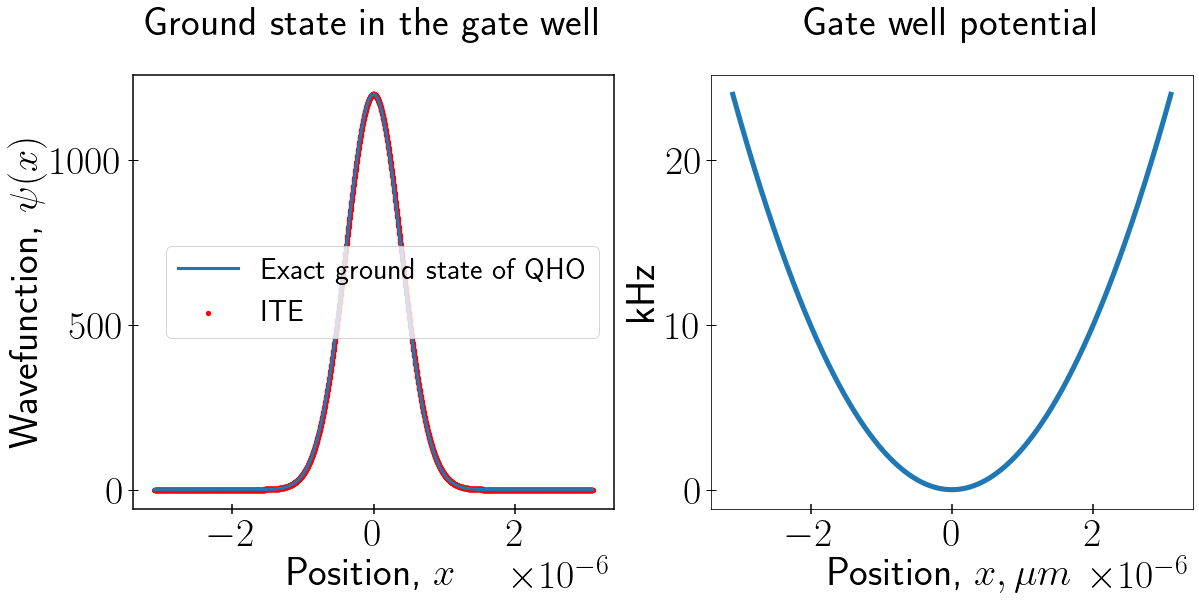

In [83]:
large = 40; med = 30; small = 20
params = {'axes.titlesize': large,
          'axes.titlepad' : large,
          'legend.fontsize': med,
          'axes.labelsize': large ,
          'axes.titlesize': large ,
          'xtick.labelsize': large ,
          'ytick.labelsize': large ,
          'figure.titlesize': large}
plt.rcParams['text.usetex'] = True
#plt.rcParams['text.latex.preamble'] = r'\usepackage{{amsmath}}'
plt.rcParams.update(params)
f = plt.figure()
plt.figure(1)

plt.subplot(121)
plt.plot(xs,psi_0(xs)/normalize(psi_0(xs)),label="Exact ground state of QHO",linewidth = 3.1)
plt.scatter(xs,abs(psi_x),s=18.1,color='red',label="ITE")
plt.legend()
plt.title('Exact wavefunction')
plt.xlabel("Position, "+r"$x$",fontweight='bold')  # Set X-axis label
plt.xticks(fontweight='bold')
plt.ylabel("Wavefunction, "+r"$\psi(x)$",fontweight='bold')  # Set Y-axis label
plt.yticks(fontweight='bold')
ax = f.gca()
ax.tick_params(axis="x", direction="inout", length=10, width=1.5, color="k")
ax.tick_params(axis="y", direction="inout", length=10, width=1, color="k")
plt.title('Ground state in the gate well')
#plt.grid(linestyle='--', alpha=0.5)
for spine in ax.spines.values():
    spine.set_linewidth(1.5)
    
plt.subplot(122)
# Plots the gate well potential.
#plt.plot(gate_well_potential(x,y)[0],gate_well_potential(x,y)[1],linewidth = 1.5)
#plt.xlabel("Position, "+r"$x ,\mu m $",fontweight='bold')  # Set X-axis label
#plt.ylabel(r"kHz")

# Plots the harmonic oscillator potential.
plt.plot(xs,V_external(xs)/(10**3*2*PI*H_BAR),linewidth = 5.1)
plt.xlabel("Position, "+r"$x ,\mu m $",fontweight='bold')  # Set X-axis label
plt.ylabel(r"kHz")

plt.xticks(fontweight='bold')
plt.yticks(fontweight='bold')
plt.title('Gate well potential')
ax = f.gca()
ax.tick_params(axis="x", direction="inout", length=10, width=1.5, color="k")
ax.tick_params(axis="y", direction="inout", length=10, width=1, color="k")
f.set_figwidth(19)
f.set_figheight(8)
plt.show()